# Chapter 7 - Point Feature Description & Matching (FAST, SIFT, SURF)

In the last chapter, we have seen how to detect corners using the Harris or Shi Tomasi Corner detection functions. We have also used a very simple descriptors to match the corner features from two different images together. 

However, our detector was quite poor since it fails as soon as the image is slightly scaled, rotated or transformed. We therefore need to find for a better descriptor than just the pixel batch around the corners. 

## 1. Overcome scale changes

We'll first look into the problem of scaling. When we have two similar images but taken from different distances to the object, our descriptor matcher would fail miserably since the two descriptors show the same thing but have very different pixel values. This can be easily illustrated in the following example of the same image at different scales with descriptors of constant size:

![Same corner at different scaled images](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_7/scale_change.png)
*Figure 1: Same corner at different scaled images. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/06_feature_detection_2.pdf)*

To react to such scale changes, we could just compare patches at different image scale levels S, but this would be computationally expensive. If we have N features per Image and S scale levels, the time complexity needed to compare all Patches at all image sizes would result in **(NS)<sup>2</sup>**.

The solution is to define a function that indicates how well the edge is perceived at different scale levels S. We can then choose take the descriptor for the optimal patch size  for both images and later match the patches since they will both be at different scale but with the same content. The resulting descriptor will always be roughly the same for all images, even at different scales. 

This approach is rather simple. Calculate the descriptor quality function by taking some different patch sizes S. Take the local maximum of the function, and take the descriptor of this patch size. Do this independently for both images and you will only end up with descriptors that are optimal for each feature. We then normalize all batches to an uniform size to make them easier to compare to each other. We do this rescaling using an appropriate interpolation method like bilinear interpolation. 

![Automatic Scale Selection](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_7/automatic_scale_selection.png)
*Figure 2: Automatic Scale Selection. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/06_feature_detection_2.pdf)*

We still have the problem that, in order to find out whether the current patch size is ideal, we'd have to calculate the cornerness function. To avoid doing this for each patch size, we can just filter the image with *Laplacian of Gaussian* kernels of different sizes. The DoG's output is high if the region contains a clear, sharp discontinuity, which is ideal for a corner. We can therefore approximate the optimal size by looking for which sized DoG filter the central pixel was at maximum. 

![Laplacian of Gaussian](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_7/laplacian_of_gaussian.png)
*Figure 3: Laplacian of Gaussian. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/06_feature_detection_2.pdf)*

## 2. Overcome Rotation changes

Now that we know how to overcome scale changes between images, we can address rotation changes. A simple but effecive way to make a patch rotation invariant is to find the direction of most dominant gradient (by using the Harris eigenvector we need anyways) and de-rotate the patch such that the most dominant gradient is exactly pointing upwards. We warp the patch by applying the warp function and interpolating at the patches pixel coordinates using Bicubic interpolation. 

![Roto-Translation warping](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_7/roto_translation_warping.png)
*Figure 4: Roto-Translation warping. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/06_feature_detection_2.pdf)*

## 3. Overcome affine Warping
Next, let's consier affine warping. This can be overcome similarly to the rotation changes by looking at the direction and magnitude of gradients. We have seen in the last chapter that a patches eigenvectors point into the direction of most and least dominant gradients, while their magnitude indicates the gradient strength. The two eigenvectors form an elipsis. We can just scale the two eigenvectors such that both eigenvectors are of the same magnitude, e.g. change the smaller eigenvalue to match the larger one. We then end up not with a ellipsis but with a circle, we essentially warp the patch always the same way to ensure we can later match them together again. 

![Affine Warping](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_7/affine_warping.png)
*Figure 5: Affine Warping. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/06_feature_detection_2.pdf)*

### Histogram of Oriented Gradient (HoG) Descriptor
The simple descriptors we have seen so far is based on taking a patch around the discovered feature. To overcome scale, rotation and affine transformation changes, we first scale, rotate and warp the patch. But this method is not just computationally expensive but also still quite sensitive, since small patch changes can result in a significantly lower score. 

A better descriptor is the so called **Historam of Oriented Gradient**, or in short just **HoG** descriptor. It does not need to wrap the patch since HoG is nearly not affected by little viewport changes of up to 50 Degrees. 

To extract the HoG descriptor of a patch, we multiply the patch by a gaussian kernel to make the shape circular rather than square. Then, we compute gradient vectors at each pixel and build a histogram of gradient orientations, weighted by the gradient magnitude. This histogram now serves us as a HoG descriptor. To make the descriptor rotation invariant, we simply do a circular shift to bring the most dominant direction to the beginning of the histogram. 
To compare two patches, we simply compare the similarity of their histograms. Since affine translations will only affect the rotations very little, the descriptor is highly flexible wihtout being actively warped. 

![Histogram of Oriented Gradient](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_7/histogram_of_oriented_gradient.png)
*Figure 6: Histogram of Oriented Gradient. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/06_feature_detection_2.pdf)*

## Scale Invariant Feature Transform (SIFT) Descriptor

As the name says, SIFT is a descriptor that is in itself scale invariant. To construct sift, we perform some simple steps. First, we multiply the patch by a gaussian filter to make it circular, exactly as we did for HoG. Then we divide each patch into 4x4 sub-patches, resulting in 16 new patches, so called *cells*. We compute HoG with 8 bins for all pixels in each cell. We concatonate all HoG into a single 1D Vector with 4x4x8 = 128 values. This vector then acts as our descriptor and can be matched using regular SSD. 

![Scale Invariant Feature Transform](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_7/scale_invariant_feature_transform.png)
*Figure 7: Scale Invariant Feature Transform, HoG symbolized as Polar Histogram. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/06_feature_detection_2.pdf)*

The descriptor vector **v** can be normalized to 1 to guarantee **affine** illumination invariance using the following formula:

![SIFT Normalization for Affine illumination invariance](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_7/sift_affine_illumination_changes.png)
*Figure 7: SIFT Normalization for Affine illumination invariance. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/06_feature_detection_2.pdf)*

SIFT is an extremely powerfull descriptor that can handle large viewport changes, out-of-plane rotations and significant changes in illumination, but it is also computationally expensive and runs on at most 10 FPS on an Intel i7 processor.

## SIFT Detector
In the last chapter, we saw the Harris corner detectors. They are rotation-invariant, which means, even if the image is rotated, we can find the same corners. It is obvious because corners remain corners in rotated image also. But what about scaling? A corner may not be a corner if the image is scaled. An image patch around a corner changes appearance when zoomed in. Hence, Harris corners are not scale invariant.

Besides being a good descriptor, SIFT also comes with a scale invariant feature detector that is not based on corners. It uses a Difference of Gaussians at different sizes to find out the best scale for a given feature. Why does it matter? Well, when we use Difference of Gaussians instead of Laplacian of Gaussians, we can apply a Gaussian filter on an image once and use it to calculate multiple difference DoG images. To calculate the DoG at four different scales, we can just calculate five Gaussians and take their sequential differences. 
As soon as one Filter gets too big, we reset the filter to its initial size and shrink the image in half. we all this step "creating a new Octave". This way, we save a lot of performance since we get the same result but with fewer convolution steps. The same is done in the opposit direction: Instead of making the filter smaller and smaller, we double the image size and reset the filter again. This creates a space-scale pyramid. 

To be more prezise, we do the following steps to create the pyramid: We convolve the initial image at original size with Gaussians G(k<sup>i</sup>o) to produce blurred images seperated by a constnat factor k in scale space. The initial Gaussian G(o) is o=1.6, k=2<sup>1/S</sup> where s is the number of intervals at each octave. When k<sup>i</sup> = 2, we diwnsample the image by a factor of 2 to create a new octve and repeat all the previous steps. Finally, from all the created Gaussian images, we substract adjacent images to create the **Difference of Gaussians**. For each DoG, we can now compare the central pixel to its 9+8+9 neighbours on the higher and lower level. Only when the pixel is a maximum of the whole region, we have successfully identified a SIFT Feature. 

![SIFT Detector with 5 octaves and 4 DoG per octave](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_7/sift_detector_octaves.png)
*Figure 8: SIFT Detector with 5 octaves and 4 DoG per octave. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/06_feature_detection_2.pdf)*

Note that a sift feature is only detected at a postion (u,v) when in a space-scale neighbourhood of 9+8+9 Pixels in the next higher and lower space region no higher-valued pixel is found.
When can finally mark all the features found by SIFT Detector with a circle, where the radius of the circle indicates the DoG Size needed to create a space-scale maximum at that position. 

![SIFT Space Scale maximum images and the resulting detected features](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_7/sift_space_scale_detector.png)
*Figure 9: SIFT Space Scale maximum images and the resulting detected features. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/06_feature_detection_2.pdf)*

This method makes the SIFT detector extremely repeatable even with large viewport changes and significant scaling. SIFT acts best with 3 score levels per octave, as impirical research has shown. 

When we use SIFT Detector with the SIFT descriptor (as it works best), we get as an output a **Descriptor**, represented by a 4x4x8=128 element vector, a pixel **location** (u, v) where the feature is located, as well as a **scale** at which the feature is most dominant and an **orientation** of the feature angle (most dominant angle in histogram). 

## Matching descriptors
Now that we have found reliable ways to describe features such that we can easily match them, we only need a good matching algorithm. The one we have seen in the last chapter just brute-force compared all descriptors together using SSD and took the one with the smallest differences as matches. However, this matching mechanism can lead to bad results. A better method is to find the best and second best match and compute the ratio d1/d2, where d1 is the calculate difference to the best match and d2 to the second best match. Only if the ratio is larger than a threshold, usualy set to 0.8, we take the match as granted. 

By applying this tactics, we minimize false matches. False matches will likely be near to other false matches due to the high dimensionality of the feature space (128 in SIFT). We can think of the second closest match as providing an estimate of the density of false matches within the portion of the feature space. 

The threshold of 0.8 was found empirically to eliminate 90% of false matches while discarding less than 5% of the correct ones, which is a good outcome. 

## Other mentionable detectors and descriptors

### Speeded Up Robust Features (SURF) Detector & Descriptor
Works similar to sift but is faster since it uses box filters instead of Difference of Gaussians, so the convolution is a bit faster and the resulting descriptor are smaller, e.g. the feature space easier to compare. 

### Features from Accelerated Segment Test (FAST) Detector
The FAST detector works differently than SIFT. It compares a circle of N (usually 16) pixel around the central pixel to the central pixel and marks them with either 1 (brighter) or 0 (darker). Only if we have all-1 pixels followed by all-0 ones, we expect the circle to contain a corner region. 
This descriptor is extremely fast. 

### Binary Robust Independent Element Features (BRIEF) Descriptor
After using FAST to find the feature locations, BRIEF is a high-speed patch descriptor. We sample randomly 256 pixel pairs in our patch and store in a vector of length 256 whether the second pixel was higher (1) or lower (0) than the first pixel. Once this pattern is generated randomly, it is reused for all other patches and images. To compare two such BREIF descriptors together, one can aply very fast Hamming distance (count the number of bits that are different) to compare two patches. Note that this descriptor is neither scale nor rotation invariant. 

### Oriented FAST and Rotated BREIF (ORB) Descriptor
We use FAST to detect the features, then use BRIEF descriptors but steered according to the keypoint orientation to make the whole thing rotation invariant. Furthermore, instead of using random pairs, ORB uses learned pairs by minimizing the correlation on a set of training patches. 

### Binary Robust Invariant Scalable Keypoints (BRISK) Descriptor
*To be written*

### Fast Retina Keypoint (FREAK) Descriptor
*To be written*

### Learned Invariant Feature Transform (LIFT) Descriptor
*To be written*

### Self-Supervised InterestPoint (SuperPoint) Detector and Descriptor
*To be written*

## Overview
![Overview over different Detectors & Descriptors](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_7/detector_descriptor_overvie_table.png)
*Figure 10: Overview over different Detectors & Descriptors. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/06_feature_detection_2.pdf)*

# Python implementation of SIFT
Now that we have talked a whole chapter about SIFT, let's use python to impelement both the SIFT Detector and then the SIFT Descriptor. 

Remember, the first step for the SIFT Descriptor is to construct the **Difference of Gaussians Pyramid**. We will use a total of 5 Octaves, from each we wish to extract 3 scale levels, with a base sigma of 1.6. In order to generate 3 scale levels, we will need 5 DoG images.

Populating the interactive namespace from numpy and matplotlib


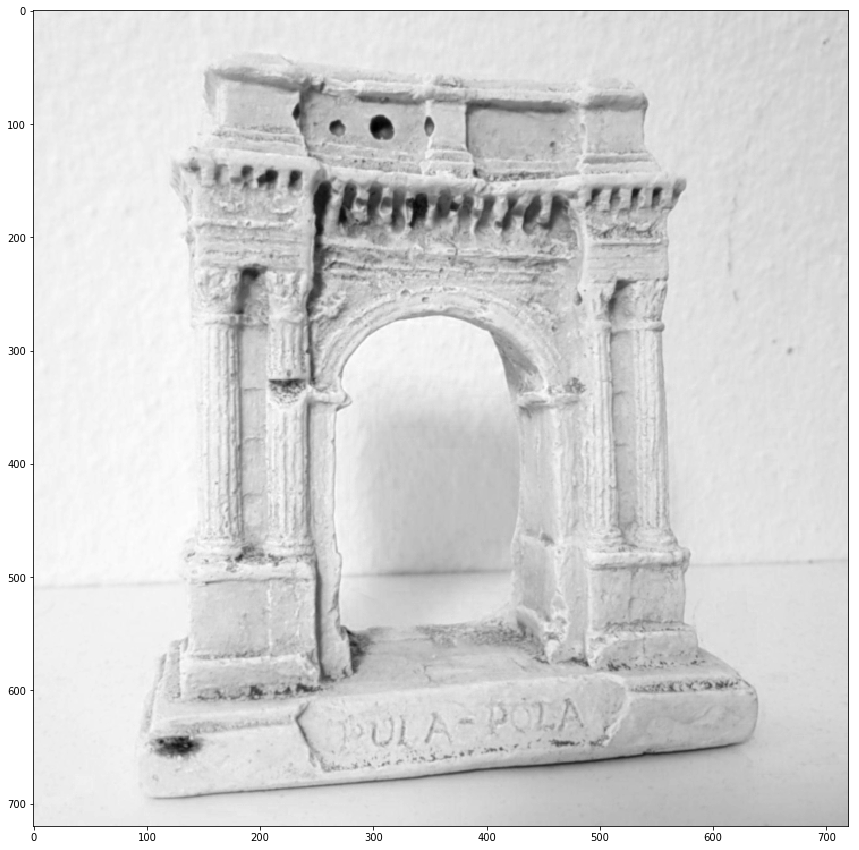

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 15)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import imresize
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import euclidean

# Number of Scales
n_scales = 3

# Number of Octaves
n_octaves = 5

# Base sigma
sigma = 1.6

# Example image (since we have a greyscale image, reduce dimensionality down to 2)
img = mpimg.imread('img/chapter_6/harris_1.jpg')[:,:,0] 
img = np.array(img, dtype=np.float32) / 255
plt.imshow(img, cmap='gray')
plt.show()

We will first write a function that takes an image and returns it blurred with a factor sigma. We also define a function that scales our image by a constant factor in both directions. For the image manipulation, we will use Scipy to rescale the image since it uses a Bicubic interpolation method. A third function shall calculate the Difference of Gaussians between two images.

c:\users\joelbarmettler\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


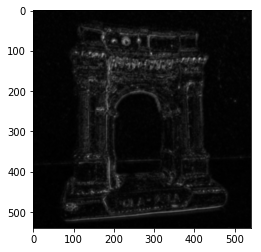

In [2]:
def blur(img, sigma):
    """
    Creates a copy of the input image and blurrs it with gaussian blur using factor sigma
    :param np.ndarray img:  Input image in greyscale format
    :param float sigma:     Gaussian Blur factor
    :return:                Blurred version of image
    :rtype: np.ndarray:
    """
    img_copy = np.array(img, copy=True, dtype=np.float32)
    blurred = np.array(gaussian_filter(img_copy, sigma), dtype=np.float32)
    if np.max(blurred) > 1:
        blurred /= 255
    return blurred
    

def resize(img, k):
    """
    Creates a copy of the input image and resizes it by fraction k
    :param np.ndarray img:  Input image in greyscale format
    :param float k:         Fraction between 0 and infinity. 0.5 halfs image size, 2 doubles it
    :return:                Scaled version of image
    :rtype: np.ndarray:
    """
    img_copy = np.array(img, copy=True, dtype=np.float32)
    resized = np.array(imresize(img_copy, float(k), interp='bicubic'), dtype=np.float32)
    if np.max(resized) > 1:
        resized /= 255
    return resized

def DoG(img1, img2):
    return np.abs(img1 - img2)

img_resized = resize(img, 0.75)
img_blured = blur(img_resized, 3.2)
dog = DoG(img_resized, img_blured)
plt.imshow(dog, cmap='gray', interpolation='bicubic')
plt.show()

Now we are ready to construct the pyramid of DoGs. Remember that we have specified to seek for 5 octaves, each with half the image size, and three scale levels per Octve, e.g. 5 DoG images per Octave, e.g. 6 input image scales per Octave. 
Seen from the other way around: Per octave, we start with 6 images blurred with different sigmas. We calculate the DoG between the subsequential ones, resulting in 5 DoGs. We then need three consecutive DoGs to extract a feature, so we are left with 3 feature scale levels. 
We repeat this step 5 times for each octave. 

![Difference of Gaussians Pyramid construction](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_7/difference_of_gaussians_pyramid.png)
*Figure 11: Difference of Gaussians Pyramid construction. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/06_feature_detection_2.pdf)*

c:\users\joelbarmettler\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


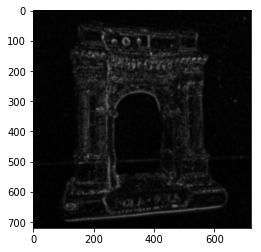

In [3]:
def computePyramid(img, n_octaves, n_scales, start_sigma=1.6, img_type=''):
    octaves = []
    for octave in range(n_octaves):
        images = []
        for scale in range(-1, n_scales+2):
            sigma = 2**(scale/n_scales) * start_sigma
            scaled_image = resize(img, 0.5**octave)
            blurred_image = blur(scaled_image, sigma)
            images.append(blurred_image)
            
        if img_type == '':
            octaves.append(images)
            
        if img_type == 'DoG':
            dogs = []
            for i in range(len(images)-1):
                dog = DoG(images[i], images[i+1])
                dogs.append(dog)
            octaves.append(dogs)
            
        if img_type == 'gradient':
            gradients = []
            for image in images:
                w,h = images[0].shape
                img_x, img_y = np.gradient(image)
                combined_gradient = np.zeros((h, w, 2))
                combined_gradient[:,:,0] = np.arctan(img_y / img_x)
                combined_gradient[:,:,1] = np.sqrt(img_y**2 + img_x**2)
                gradients.append(combined_gradient)
            octaves.append(gradients)
            
    return octaves

dog_pyramid = computePyramid(img, n_octaves, n_scales, sigma, img_type='DoG')
plt.imshow(dog_pyramid[0][0], cmap='gray', interpolation='bicubic')
plt.show()

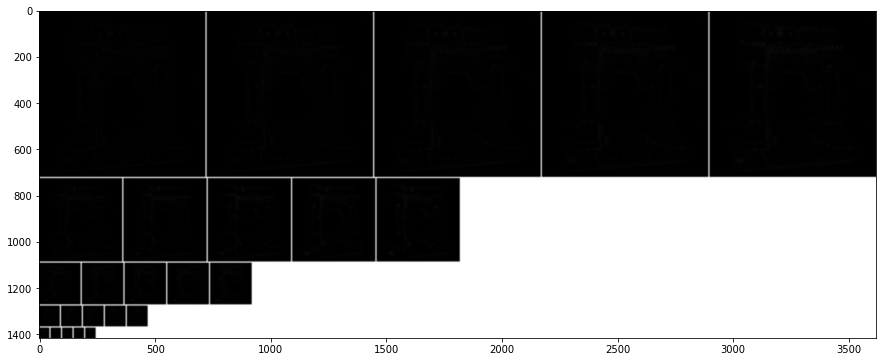

In [4]:
pylab.rcParams['figure.figsize'] = (15, 15)

def visualizePyramid(pyramid):
    width, height = 0, -5
    for octave in pyramid:
        img = octave[0]
        height += len(img) + 5
        width = max(width, len(img[0]) * len(octave) + 5*(len(octave)-1))
        
    visualization = np.ones((height, width), dtype=np.float32)
    
    shift_width, shift_height = 0, 0
    for octave in pyramid:
        shift_width = 0
        for img in octave:
            img_height, img_width = img.shape
            visualization[shift_height : shift_height+img_height,
                          shift_width  : shift_width+img_width    ] = img
            shift_width += (img_width + 5)
        shift_height += (len(octave[0])+5)
    
    return visualization

vis = visualizePyramid(dog_pyramid)
plt.imshow(vis, cmap='gray', interpolation='bicubic')
plt.show()

Cool, we have a pyramid of DoG's now. The only thing left to do is finding maximum points between three consecutive DoG points and mark them as features. We'll write a function that takes the pyramid as input and calculates a set of (x, y) coordinates where features (local maxima) are found. 

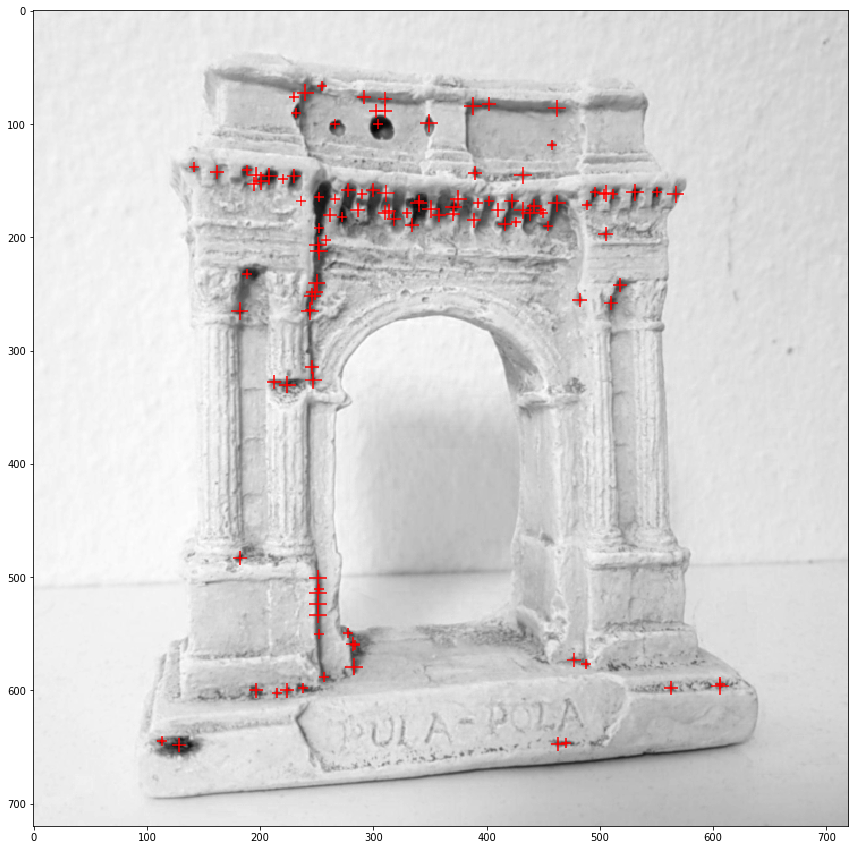

In [5]:
def extractFeatures(pyramid, threshold=0.04):
    x_positions, y_positions, octaves, scales = [], [], [], []
    for n_octave in range(len(pyramid)):
        octave = pyramid[n_octave]
        for i in range(1, len(octave)-1):
            img_before = octave[i-1]
            img = octave[i]
            img_after = octave[i+1]
            for y in range(1, len(img)-1):
                for x in range(1, len(img[0])-1):
                    central_pixel = img[y][x]
                    if central_pixel < threshold:
                        continue
                    patch = np.zeros((3,3,3))
                    patch[:, :, 0] = img_before[y-1:y+2, x-1:x+2]
                    patch[:, :, 1] = img[y-1:y+2, x-1:x+2]
                    patch[:, :, 2] = img_after[y-1:y+2, x-1:x+2]
                    patch[1, 1, 1] = 0
                    if central_pixel > np.max(patch):
                        x_positions.append(x*(2**n_octave))
                        y_positions.append(y*(2**n_octave))
                        octaves.append(n_octave)
                        scales.append(i)
    return np.array(x_positions), np.array(y_positions), np.array(octaves), np.array(scales)

x_positions, y_positions, octaves, scales = extractFeatures(dog_pyramid)

plt.imshow(img, cmap='gray')
plt.scatter(x=x_positions, y=y_positions, c='r', s=np.array(scales)*100, marker='+')
plt.show()

Now that we know where the SIFT features are, let's try to extract the SIFT descriptor as well. To do so, we write a function that takes the image, the descriptor coordinates (x,y) and the scale at which the descriptor was found. We will then perform the following steps to extract the descriptor:

- If the keypoint has been detected in Octave O with scale S, the image we have to use to compute the gradients should be the image in with index S-1 from octave O. 
- We extract a 16x16 patch around the keypoint coordinates and generate the norm and orientation of the x,y-spatial gradients of the image selected before. We'll need to write this gradient function first. 
- We then scale the norm of the gradient by their distance to the center by multiplying the gradient norms with the gaussian centered in the keypoint using sigma=1.5 * 16. 
- Then, we divide the 16x16 patch into 4 sub-patches of size 4x4. For each sub-block, a 8 bin orientation histogram is created, with gradients weighted by their norm. 
- Finally, we concatenate the histograms into a 128 element vector. After normalizing the vector such that it has a norm of 1, we can return it as the descriptor.

In [6]:
gradient_pyramid = computePyramid(img, n_octaves, n_scales, sigma, img_type='gradient')

def extractDescriptor(gradient_pyramid, octave, scale, x, y):
    
    x, y = x//2**octave, y//2**octave    
    patch_angle = gradient_pyramid[octave][scale-1][y-8:y+8, x-8:x+8, 0]
    patch_magnitude = gradient_pyramid[octave][scale-1][y-8:y+8, x-8:x+8, 1]
        
    gx, gy = np.meshgrid(np.linspace(-1,1,16), np.linspace(-1,1,16))
    gaussian_grid = np.exp(-((np.sqrt(gx*gx+gy*gy)**2 / (2.0))))
    patch_magnitude *= gaussian_grid    
    descriptor = np.zeros((128, ), dtype=np.float32)
    
    i = 0
    for y in range(0, 16, 4):
        for x in range(0, 16, 4):
            cell_angle = patch_angle[y:y+4, x:x+4]
            cell_magnitude = patch_magnitude[y:y+4, x:x+4]
                        
            vector_angle = np.reshape(cell_angle, (16,1))
            vector_magnitude = np.reshape(cell_magnitude, (16,1))
            
            hist, _ = np.histogram(vector_angle, range=(-np.pi, np.pi), bins=8, weights=vector_magnitude)
            descriptor[i:i+8] = hist
            i += 8
            
    # Normalize descriptor
    descriptor /= np.linalg.norm(descriptor)
    
    # Shift the descriptor to bring max bucket to the beginning, making it rotation invariant
    # max_index = np.argmax(descriptor)
    # descriptor = np.roll(descriptor, -max_index)
    
    return descriptor

descriptors = []
for i in range(len(x_positions)):
    descriptor = extractDescriptor(gradient_pyramid, octaves[i], scales[i], x_positions[i], y_positions[i])
    descriptors.append(descriptor)
    
descriptors[0]

c:\users\joelbarmettler\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
c:\users\joelbarmettler\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
c:\users\joelbarmettler\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


array([0.00000000e+00, 0.00000000e+00, 8.84429142e-02, 2.82376185e-02,
       0.00000000e+00, 9.42827761e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.88186932e-02, 7.49834208e-03,
       1.03005819e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.50005985e-02, 5.59348576e-02,
       1.36426061e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.06868470e-02, 5.27542084e-03,
       1.15400378e-03, 5.55705279e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.08748063e-01, 1.68812737e-01,
       3.58797200e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.21956384e-01, 4.35618088e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.79778799e-01, 1.13926552e-01,
       1.65450886e-01, 3.69548947e-02, 0.00000000e+00, 0.00000000e+00,
      

Now that we have computed the descriptors for all our features, we need a clever way to match them. 

In [21]:
def match_descriptors(descriptors_1, descriptors_2, threshold = 0.8, max_distance = 0.8):
    
    # matches[i] = j
    # The descriptor in image 1 at position i matches the descriptor in image 2 with index j.
    # -1 for descriptors in image 1 that have no match in image 2
    matches = np.ones((len(descriptors_1), ), dtype=np.int8) * -1
    
    # Loop over descriptors from image 1
    for i in range(len(descriptors_1)):
        d1 = descriptors_1[i]
        best_distance = 1
        second_best_distance = 1
        
        # Loop over descriptors in image 2
        for j in range(len(descriptors_2)):
            d2 = descriptors_2[j]
            
            distance = euclidean(d1, d2)
            
            # Replace value at index i only if ssd is better, the descriptor in image 2 is not yet matched
            # to any descriptor in image 1, and the descriptor is good enough
            if distance < best_distance:
                matches[i] = j
                second_best_distance = best_distance
                best_distance = distance
        if best_distance / second_best_distance > threshold or best_distance > max_distance:
            matches[i] = -1
            
    # Feturn matches array
    return matches

In [8]:
# Image 1
img_1 = np.array(mpimg.imread('img/chapter_6/harris_1.jpg')[:,:,0] , dtype=np.float32) / 255
dog_pyramid_1 = computePyramid(img_1, n_octaves, n_scales, sigma, img_type='DoG')
gradient_pyramid_1 = computePyramid(img_1, n_octaves, n_scales, sigma, img_type='gradient')
x_positions_1, y_positions_1, octaves_1, scales_1 = extractFeatures(dog_pyramid_1)
descriptors_1 = [extractDescriptor(gradient_pyramid_1, octaves_1[i], scales_1[i], x_positions_1[i], y_positions_1[i]) for i in range(len(x_positions_1))]

# Image 2
img_2 = np.array(mpimg.imread('img/chapter_6/harris_2.jpg')[:,:,0] , dtype=np.float32) / 255
dog_pyramid_2 = computePyramid(img_2, n_octaves, n_scales, sigma, img_type='DoG')
gradient_pyramid_2 = computePyramid(img_2, n_octaves, n_scales, sigma, img_type='gradient')
x_positions_2, y_positions_2, octaves_2, scales_2 = extractFeatures(dog_pyramid_2)
descriptors_2 = [extractDescriptor(gradient_pyramid_2, octaves_2[i], scales_2[i], x_positions_2[i], y_positions_2[i]) for i in range(len(x_positions_2))]

c:\users\joelbarmettler\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
c:\users\joelbarmettler\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
c:\users\joelbarmettler\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


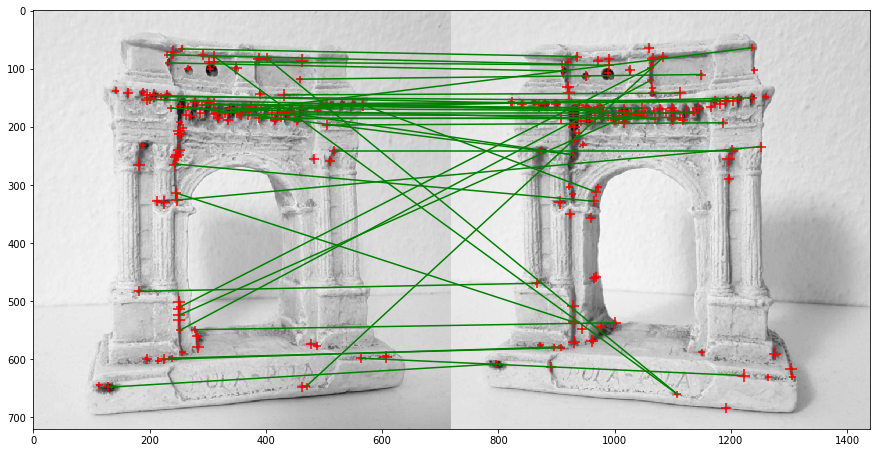

In [22]:
# Calculate matches
matches = match_descriptors(descriptors_1, descriptors_2)

# Create a combined image and shift the x positions of the second image
combined_img = np.concatenate((img_1, img_2), axis=1)
x_positions_2_shifted = x_positions_2 + len(img_2[0])
plt.imshow(combined_img, cmap='gray')

# Draw lines between all descriptors that have valid matches (> -1)
for i in range(len(matches)):
    match = matches[i]
    if match > -1:
        plt.plot([x_positions_1[i], x_positions_2_shifted[match]], [y_positions_1[i], y_positions_2[match]], c='g')

# Plot descriptors for each image
plt.scatter(x=x_positions_1, y=y_positions_1, c='r', s=scales_1*50, marker='+')
plt.scatter(x=x_positions_2_shifted, y=y_positions_2, c='r', s=scales_2*50, marker='+')